In [1]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from pulse_pair_doppler import pulse_pair_doppler

In [2]:
# TODO add satellite motion (decorrelation of phase after half satellite motion in approx 0.25 ms)
# TODO add surface decorrelation FIXME find correct decorrelation rate (linear over time?, exponential?)
# TODO does dopsca work with subswaths and scans?

model = pulse_pair_doppler(
    t_pulse=1.15e-4,                   # s
    t_receive=20e-4,                # s 
    t_interpulse=0*1e-4,              # s
    t_decor=3e-3,                   # s
    # n_reflectors=4,            # -    TODO why does this number increase error?
    # temporal_coherence = 0.50,
    n_pulses=2,                     # -
    n_bursts=35,                    # -
    bandwidth=1e6,                  # hz
    baseband=0,                     # hz   TODO why does this number increase error?
    oversample_retriev=1,           # -    TODO why does this number increase error?
    range_cell_avg_factor=1,        # -
    range_cell_size_frac_pulse=1,   # -
    seed=12,                         # -
)

# Single Burst

In [3]:
model.chirp(centre_around_baseband=True)
model.pulse_pairs()
model.simulate_reflection()
model.pulse_compress(window_function=False)
model.delayed_autocorrelation()
model.phase_difference()

Autocorrelation cell: 100%|██████████| 13/13 [00:00<00:00, 10425.61it/s]


pulse_pair_doppler(t_pulse=0.000115, t_receive=0.002, t_interpulse=0.0, n_pulses=2, n_bursts=35, bandwidth=1000000.0, baseband=0, seed=12, t_decor=0.003, temporal_coherence=0.998531634660417, n_reflectors=None, oversample_retriev=1, range_cell_avg_factor=1, range_cell_size_frac_pulse=1)

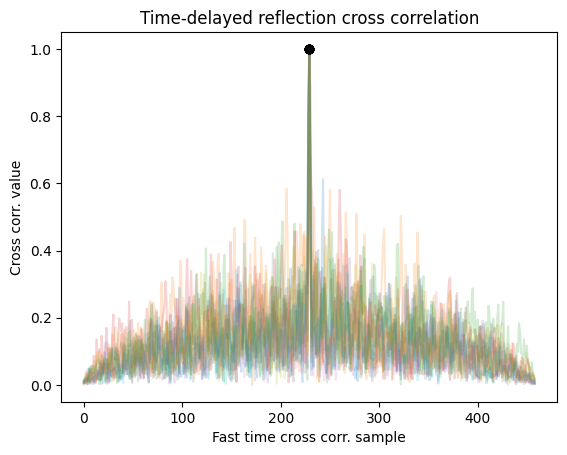

In [4]:
sig = abs(model.corr.T)
sig /= np.max(sig, axis = 0)
peaks = np.argmax(sig, axis = 0)

plt.figure()
plt.title("Time-delayed reflection cross correlation"); plt.xlabel("Fast time cross corr. sample"); plt.ylabel("Cross corr. value"); 
plt.plot(sig, alpha = 0.2, zorder = 1)
plt.scatter(peaks, sig[peaks, np.arange(len(model.corr))], c = 'k', zorder =2)

In [5]:
if model.n_reflectors is not None:
    # arb_cross_corr_limit = np.min(np.sort(np.max(sig, axis = 0), axis=0)[-model.n_reflectors:])
    # phase_diff = model.phase_diff_avg_rg[sig.max(axis= 0) >= arb_cross_corr_limit]
    wvc_cell = np.unique(np.where(abs(model.surface) > 0)[0] // len(model.pulse) - 2 )
    wvc_cell = wvc_cell[(wvc_cell>=0) & (wvc_cell< len(model.phase_diff_avg_rg))]
    phase_diff = model.phase_diff_avg_rg[wvc_cell]
    print(f"WVC: {wvc_cell}, \nwith phase diff.: \n{phase_diff}")
else:
    phase_diff = model.phase_diff_avg_rg

phase_diff_rmse = np.sqrt(np.mean(phase_diff**2))

c = 3e8 # m/s
Lambda = 0.05 # c/f # m
t_delta = model.t_pulse + model.t_interpulse

LoS_velocity_phase = phase_diff * Lambda / (2*np.pi * t_delta)
LoS_velocity_phase_rmse = phase_diff_rmse * Lambda / (2*np.pi * t_delta)

print(f"\n RMSE phase error of: {phase_diff_rmse:.4f} rad, which is equal to {LoS_velocity_phase_rmse:.3f} m/s ")


 RMSE phase error of: 0.1126 rad, which is equal to 7.795 m/s 


# Multi burst

In [34]:
_ = model.azimuth_average(window_function=False)

Burst number: 100%|██████████| 35/35 [00:00<00:00, 703.94it/s]


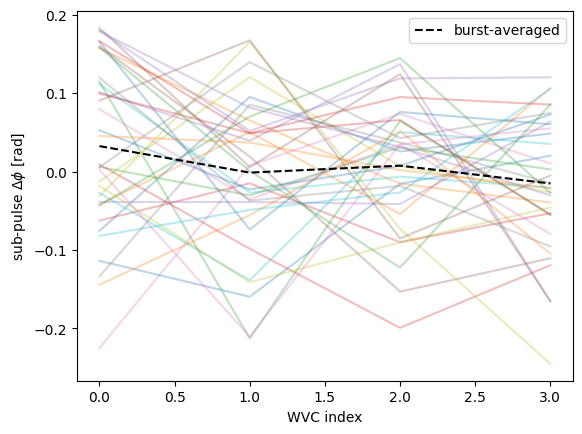

In [35]:
plt.plot(model.phase_diff_avg_rg.T, alpha = 0.3)
plt.plot(model.phase_diffs_avg_rg_az, 'k--', label = 'burst-averaged')
plt.xlabel('WVC index'); plt.ylabel('sub-pulse $\Delta \phi$ [rad]')
plt.legend()

In [36]:
phase_diff = model.phase_diffs_avg_rg_az[:]

phase_diff_rmse = np.sqrt(np.mean(phase_diff**2))

c = 3e8 # m/s
Lambda = 0.05 #c/f # m
t_delta = model.t_pulse + model.t_interpulse

LoS_velocity_phase = phase_diff * Lambda / (2*np.pi * t_delta)
LoS_velocity_phase_rmse = phase_diff_rmse * Lambda / (2*np.pi * t_delta)

print(f"\n RMSE phase error of: {phase_diff_rmse:.4f} rad, which is equal to {LoS_velocity_phase_rmse:.3f} m/s ")


 RMSE phase error of: 0.0184 rad, which is equal to 1.271 m/s 


# Sub-pulse Decorrelation

In [9]:
def coherence_calc(signal1, signal2):

    # Yields similar performance as the mean output from scipy.signal.coherence using a 'hann' window

    # Compute the cross-power spectral density (CSD)
    csd = np.mean(signal1 * np.conj(signal2))

    # Compute the power spectral density (PSD) for each signal
    psd_signal1 = np.mean(np.abs(signal1)**2)
    psd_signal2 = np.mean(np.abs(signal2)**2)

    # Calculate the coherence using the CSD and PSD values
    coherence = np.abs(csd)**2 / (psd_signal1 * psd_signal2)

    return coherence

In [10]:
# NOTE we assume a linear decorrelation over time
t_surface_decorr = 3e-3

errors = []
coherences = []
pulse_lengths = np.logspace(-5, -3.6, 100)

for t in tqdm(pulse_lengths):
    
    model.t_interpulse = 0
    model.t_pulse = t 

    # TODO choose coherence loss model exponential coherenc eloss
    # target_coherence = np.exp(np.log(2) * (1 - (model.t_pulse + model.t_interpulse) / t_surface_decorr )) -1  # exponential
    target_coherence = 1- (model.t_pulse + model.t_interpulse) / t_surface_decorr # linear
    target_coherence = 0 if target_coherence <= 0 else target_coherence
    
    model.temporal_decorr = target_coherence
    model.azimuth_average(window_function=False, azimuth_progress_bar_dissable=True)

    phase_diff = model.phase_diffs_avg_rg_az[:]
    phase_diff_rmse = np.sqrt(np.mean(phase_diff**2))
    LoS_velocity_phase_rmse = phase_diff_rmse * Lambda / (2*np.pi * t_delta)

    sample_offset = model.pulse_samples + model.interpulse_samples
    real_coherence = coherence_calc(model.subreflections[0][:-sample_offset], model.subreflections[1][sample_offset:])
    
    coherences.append(real_coherence)
    errors.append(LoS_velocity_phase_rmse)

100%|██████████| 100/100 [00:07<00:00, 12.88it/s]


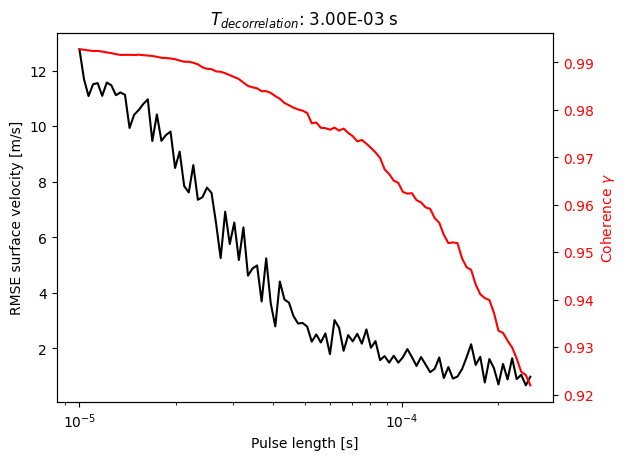

In [11]:
fig, ax1 = plt.subplots()

# Plot the first dataset on the first y-axis
ax1.semilogx(pulse_lengths, errors, color='k')
ax1.set_xlabel('Pulse length [s]')
ax1.set_ylabel('RMSE surface velocity [m/s]', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Create a second set of axes that shares the same x-axis
ax2 = ax1.twinx()

# Plot the second dataset on the second y-axis
ax2.semilogx(pulse_lengths, coherences, color='r')
ax2.set_ylabel('Coherence $\gamma$', color='r')
ax2.tick_params(axis='y', labelcolor='r')


plt.title("$T_{decorrelation}$: "+ f"{t_surface_decorr:.2E} s")
plt.show()